# Detecting Anomalies in Telecom Network Behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
sns.set(style="whitegrid")

# Load Data
PROCESSED_PATH = "../data/processed/parquet/"
df = pd.read_parquet(PROCESSED_PATH + "network_behaviors.parquet")

# 1️⃣ Overview

In [3]:
print(df.info())
print(df.describe())
print("Label distribution:")
print(df["anomaly"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   latency_ms   8400 non-null   float64
 1   packet_loss  8400 non-null   float64
 2   cpu_load     8400 non-null   float64
 3   anomaly      8400 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 229.8 KB
None
        latency_ms  packet_loss     cpu_load      anomaly
count  8400.000000  8400.000000  8400.000000  8400.000000
mean    101.972074     0.011866     0.508033     0.018452
std      20.324246     0.014339     0.113515     0.134588
min      43.787526    -0.009178     0.138931     0.000000
25%      90.187524     0.006786     0.435130     0.000000
50%     100.472084     0.010069     0.502186     0.000000
75%     110.772292     0.013579     0.573839     0.000000
max     282.059287     0.123785     1.142515     1.000000
Label distribution:
anomaly
0    0.981548
1    0.018452
Name: p

# 2️⃣ Feature Selection and Scaling

In [4]:
features = ["latency_ms", "packet_loss", "cpu_load"]
X = df[features]
y_true = df["anomaly"]  # for evaluation only

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Train Isolation Forest

In [5]:
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_scaled)

# Predict: -1 means anomaly, 1 means normal
preds = model.predict(X_scaled)
y_pred = np.where(preds == -1, 1, 0)  # Convert to binary labels

# 4️⃣ Evaluation

In [6]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8245
           1       0.37      1.00      0.54       155

    accuracy                           0.97      8400
   macro avg       0.68      0.98      0.76      8400
weighted avg       0.99      0.97      0.98      8400


Confusion Matrix:
[[7980  265]
 [   0  155]]


# 5️⃣ KDE Plot of Latency by Prediction

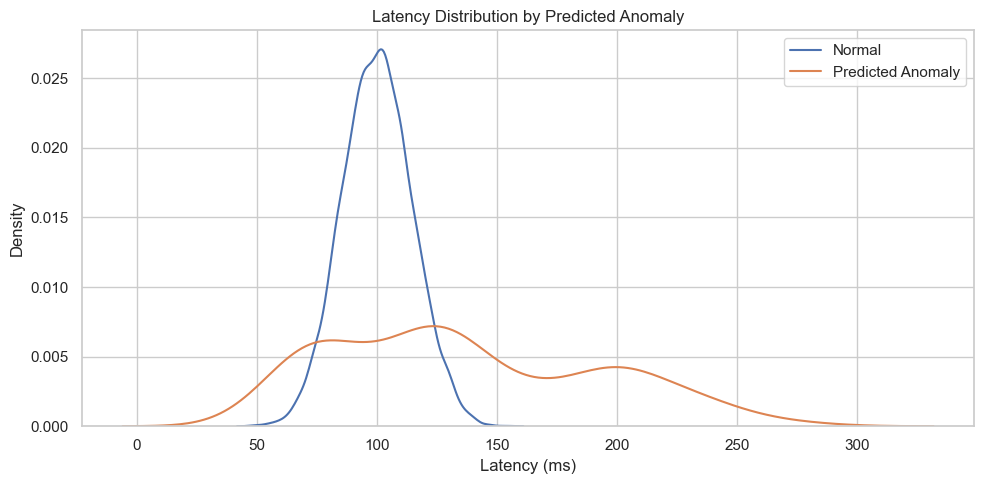

In [7]:
df["predicted_anomaly"] = y_pred

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df[df.predicted_anomaly == 0]["latency_ms"], label="Normal")
sns.kdeplot(data=df[df.predicted_anomaly == 1]["latency_ms"], label="Predicted Anomaly")
plt.title("Latency Distribution by Predicted Anomaly")
plt.xlabel("Latency (ms)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import joblib
joblib.dump(model, "../models/anomaly_model.pkl")
joblib.dump(scaler, "../models/anomaly_scaler.pkl")

['../models/anomaly_scaler.pkl']